# Semi-Supervised Zebrafish Behavioral Classification

Note: Please use the conda envirnoment contained in this file directory. It has all the appropriate downloads. Version: Python 3.12.2

In [1]:
import numpy as np
import pandas as pd
import random
import sklearn.ensemble
import sklearn.model_selection
import umap
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import random_center_initializer
import pathlib

# Import custom library
import os
import sys

try: # To prevent this section from being run more than once. This is not necessary if you don't use Path.cwd().parent, which can't be run more than once.
    shuffle_dir
except:
    ## Directory containing data (and anything specific to this particular shuffle)
    shuffle_dir = os.path.split(os.getcwd())[-1]
    ## Directory containing packages and videos
    proj_dir = pathlib.Path.cwd().parent
    os.chdir(proj_dir)

print('Current Working Directory: ' + str(pathlib.Path.cwd()))
print('Shuffle Directory: ' + str(shuffle_dir))

from TopViewFishClassification.tail_classification import classification, video, visualization

Current Working Directory: /Users/iman/Desktop/Zebrafish Kinematic Classification Pipeline
Shuffle Directory: DLC_Trial3_shuffle1


In [2]:
np.random.seed(0)
random.seed(0)

## Train Random Forest Classifier to Differentiate Between Active and Inactive States

The following blocks of code train a random forest classifier from the Scikit Learn library (see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html for more info) to differentiate between frames in which the zebrafish is exhibiting activity and frames in which it is exhibiting rest (a frame of rest is defined as a frame over which the zebrafish doesn't display any purposeful movement). This classifier is trained on the features extracted from pre-processing of the raw DLC data. 

### Arrange Data Into Training and Test Sets

In [3]:
# The data from all of the recordings which will be included in training and testing
csvs = [shuffle_dir + '/Extracted Features/240523_hcrt-reachr_cFos_1s_1IPI_#4.csv',
        shuffle_dir + '/Extracted Features/240523_hcrt-reachr_cFos_1s_1IPI_#5.csv',
        shuffle_dir + '/Extracted Features/240523_hcrt-reachr_cFos_1s_1IPI_#6.csv',
        shuffle_dir + '/Extracted Features/240524_hcrt-reachr_cFos_constantON_#2.csv']
dfs = []
for path in csvs:
    df = pd.read_csv(path)
    df = df.drop([df.columns[0]], axis=1)
    dfs.append(df)

In [4]:
# Divides Data Into Train and Test Sets and formats the data for input into sklearn classifier
datas, x_train, y_train, x_test, y_test, x, y = classification.compile_tree_data(dfs)

print("Labelled Dataset Size: " + str(len(x)))
print("Training Dataset Size: " + str(len(x_train)))
print("Test Dataset Size: " + str(len(x_test)))


Labelled Dataset Size: 37298
Training Dataset Size: 35432
Test Dataset Size: 1866


### Train and Validate Model

In [5]:
# Initialize Model
clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy', min_samples_leaf=5, random_state=0)
# Train Model
clf.fit(x_train, y_train)

# Validate Model
validation = np.mean(sklearn.model_selection.cross_val_score(clf, x_train, y_train, cv=10))
print("Validation: " + str(validation))

Validation: 0.8963603876017888


### Evaluate Accuracy of Model

In [6]:
# Get training, test, and labelled set accuracy
pred_train = clf.predict(x_train)
train_acc = sklearn.metrics.accuracy_score(y_train, pred_train)
print("Training Accuracy: " + str(train_acc))
pred_test = clf.predict(x_test)
test_acc = sklearn.metrics.accuracy_score(y_test, pred_test) 
print("Test Accuracy: " + str(test_acc))
pred = clf.predict(x)
accuracy = sklearn.metrics.accuracy_score(y, pred)
print("Overall Accuracy: " + str(accuracy))

# Estimate the accuracy if a filter is applied to get rid of intervals of rest or activity of less than 3 frames
# Note: this will apply filters to the boundaries between videos, but this mostly acts as 
# an estimate so this is ok. Probably don't use this for further analysis though
new_pred = classification.pd_rolling(pd.Series(data=pred), 5, np.median, right_leaning=True).to_numpy()
new_pred = classification.pd_rolling(pd.Series(data=pred), 5, np.median, right_leaning=True).to_numpy()
filtered_accuracy = sklearn.metrics.accuracy_score(y, new_pred)
print("Overall Accuracy After Filter: " + str(filtered_accuracy))

Training Accuracy: 0.995540754120569
Test Accuracy: 0.9710610932475884
Overall Accuracy: 0.9943160491179152
Overall Accuracy After Filter: 0.9910987184299426


In [7]:
# Breakdown of how the model performs in comparison to the manually labelled data
active_incorrect = (pred[y==1] != 1).sum() / (pred!=y).sum()
new_active_incorrect = (new_pred[y==1]!=1).sum()/(new_pred!=y).sum()
train_active_incorrect = (pred_train[y_train==1] != 1).sum() / (pred_train != y_train).sum()
test_active_incorrect = (pred_test[y_test==1] != 1).sum() / (pred_test != y_test).sum()
print("Percent of Incorrect Frames That Are Active: " + str(active_incorrect))
print('Percent of Incorrect Frames That Are Active After Filter: ' + str(new_active_incorrect))
print("Percent of Incorrect Training Frames That Are Active: " + str(train_active_incorrect))
print("Percent of Incorrect Test Frames That Are Active: " + str(test_active_incorrect))

Percent of Incorrect Frames That Are Active: 0.6650943396226415
Percent of Incorrect Frames That Are Active After Filter: 0.6716867469879518
Percent of Incorrect Training Frames That Are Active: 0.6455696202531646
Percent of Incorrect Test Frames That Are Active: 0.7222222222222222


### Display Random Forest Model Performance

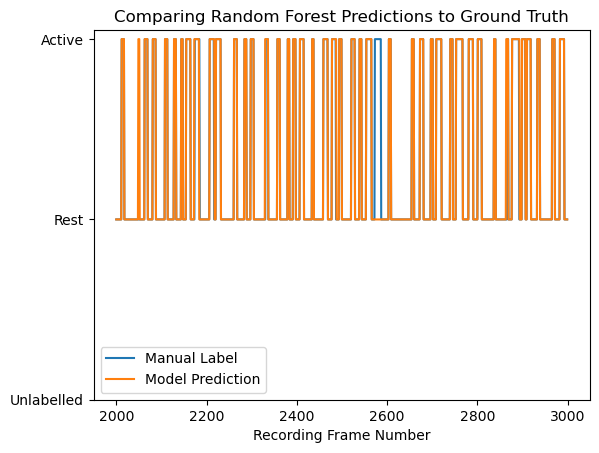

In [8]:
visualization.display_random_forest_performance(dfs, datas, clf, 3, title = 'Comparing Random Forest Predictions to Ground Truth', filter_window = 5, slice=[2000,3000])

## Unsupervised Classification of Intervals of Activity into Kinematic Behavioural States
The following code blocks will classify the intervals of activity (defined as a blocks of consecutive active frames) into different behavioral states. This will be accomplished in three steps:

    (1) Use a distance metric to quantify the similarity of each interval to all other intervals. The extracted distances will be saved in a distance matrix
    (2) (This step is optional) Reduce the dimensionality of the distance matrix. This can be helpful as most dimensionality reduction algorithms will capture important relationships between the datapoints based upon the entire dataset. Applying dimensionality reduction before clustering allows the clustering algorithm to use these relationships when considering how to best divide the data.
    (3) Use a clustering method to divide the data into different behavioral states based upon the relative distances (or reduced distances) between the intervals   

### Retrieve Intervals Defined By Consecutive Frames of Activity

In [9]:
# Compile array with the information to locate all intervals of activity
intervals = classification.get_active_intervals(datas, clf, median_filter_window=5)

### Compare All Behaviors Using Dynamic Time Warping Distance
The intervals that have been extracted from the data above are all of different lengths and may exhibit behaviors that proceed at slightly different speeds or start within the interval at different times. In the following code, dynamic time warping is used to get a sense of how these intervals are related to each other. Dynamic Time Warping is a method of measuring the similarity between two temporal sequences that accounts for differences in the sequences' speeds and time shifts. In other words, dynamic time warping attempts to quantify the similarity in shape between two temporal sequences as opposed to comparing them value by value. The Dynamic Time Warping algorithm works by matching each of the points along the time sequence so as to minimize the differences between the two time sequences before taking the difference between the two time sequences. In this case, euclidean distance is used to find quantify the difference between two time-warped intervals.  

For more information see:
- https://www.youtube.com/watch?v=ERKDHZyZDwA => For a quick introduction to dynamic timewarping
- https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html => this is the documentation for the package that was used

In [10]:
correlation = classification.generate_correlation_matrix(intervals, dfs)

### Dimensionality Reduction of the Dynamic Time Warping Distances Using UMAP
Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) is a dimensionality reduction technique. The advantanges of this particular technique over others (such as prinincipal component anaylis) is that it finds nonlinear (rather than only linear) relationships between datapoints and does so in a more efficient manner than other similar dimensionality reduction techniques. 

For more information see:
- https://umap-learn.readthedocs.io/en/latest/how_umap_works.html => on how UMAP works
- https://umap-learn.readthedocs.io/en/latest/clustering.html => for how UMAP can be used along with clustering algorithms

In [11]:
reducer = umap.UMAP(n_neighbors = 100, min_dist = 0, n_components=10, random_state=1)
reduced_correlation = reducer.fit_transform(correlation)

/Users/iman/Desktop/Zebrafish Kinematic Classification Pipeline/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Clustering Intervals Using K-Medoids Clustering
K-Medoids clustering is a clustering method that finds an n number of datapoints, called medoids, that best represent the variance in the data. The state of the remaining datapoints are then defined by the closest medoid. The advantage to k-medoids clustering, in comparison to k-means clustering, is that it is signficantly affected by outlying values but it is less efficient. Another reason to use k-medoids clustering is that the medoids provide a representative interval of activity for each behavioral state.

In [12]:
# Define how many behavioral state clusters there should be
state_num = 3

# This sets the initial value for the mediods
initializer = random_center_initializer(correlation, state_num, random_state=1).initialize(return_index = True)
# Trains model and gets cluster and medoid indices
model = kmedoids(reduced_correlation, initializer)
model.process()
clusters = model.get_clusters()
medoids = model.get_medoids()

## Visualizing Clustered Behavioral States

In [13]:
# Upload the DLC data with low-certainty data reevaluated for visualization of the clustered behavioral states
position_csvs = [shuffle_dir + '/Interpolated DLC Data/240523_hcrt-reachr_cFos_1s_1IPI_#4.csv',
                 shuffle_dir + '/Interpolated DLC Data/240523_hcrt-reachr_cFos_1s_1IPI_#5.csv',
                 shuffle_dir + '/Interpolated DLC Data/240523_hcrt-reachr_cFos_1s_1IPI_#6.csv',
                 shuffle_dir + '/Interpolated DLC Data/240524_hcrt-reachr_cFos_constantON_#2.csv']
pdfs = []
for path in position_csvs:
    pdf = pd.read_csv(path)
    pdf = pdf.drop([pdf.columns[0]], axis=1)
    eyes = ['Upper Left Eye x', 'Upper Left Eye y', 'Lower Left Eye x', 'Lower Left Eye y', 'Upper Right Eye x', 'Upper Right Eye y', 'Lower Right Eye x', 'Lower Right Eye y']
    # remove eye data
    pdf = pdf.drop(eyes, axis=1)
    pdf = pdf.iloc[:, [10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]] # rearrange points so that they are in the proper order according to the fish skeleton
    pdfs.append(pdf)

### Visualize Behavioral State Medoids

Your animation was successfully saved in DLC_Trial3_shuffle1/Visualizations/animation.gif and DLC_Trial3_shuffle1/Visualizations/animation.mov!


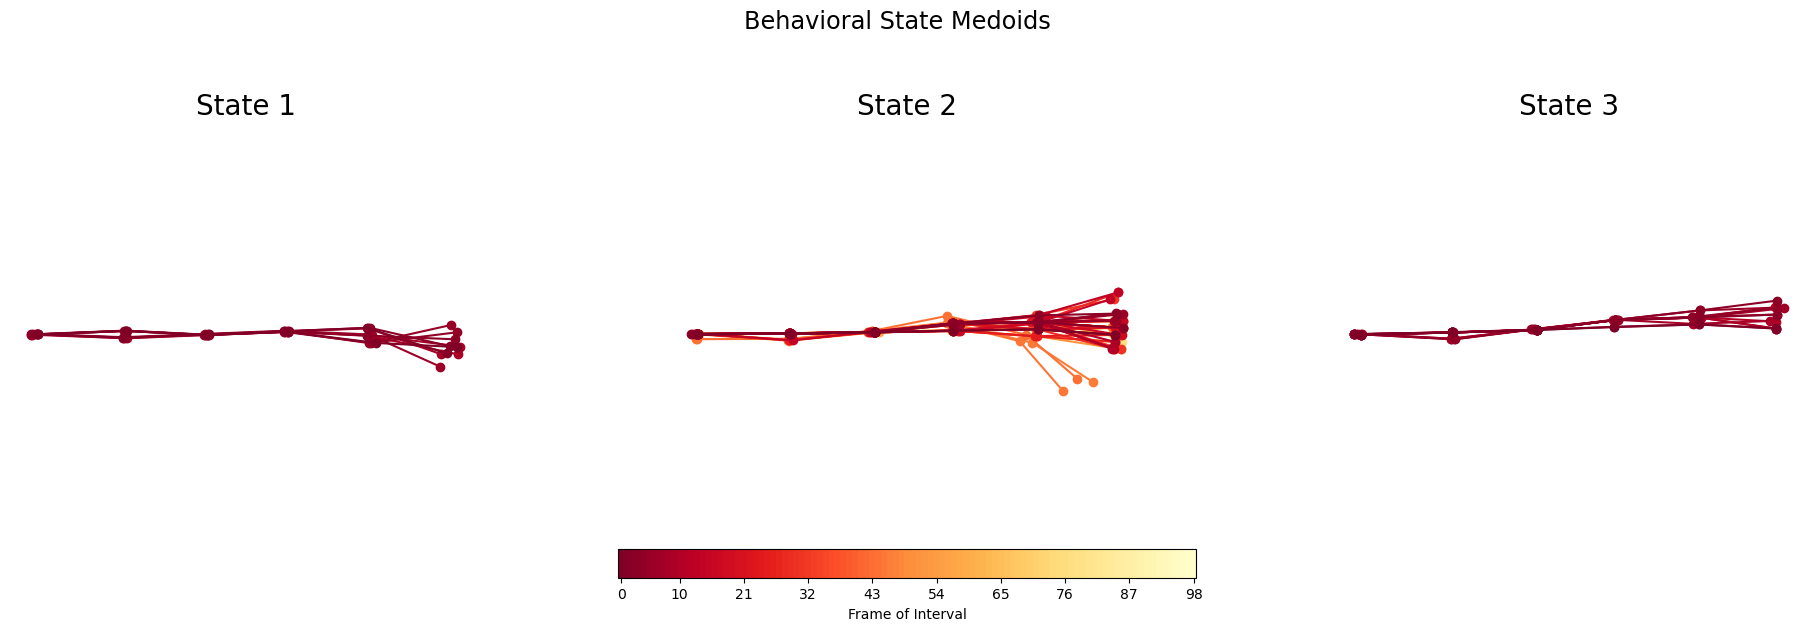

In [14]:
# Define how each behavioral state should be named
state_titles = []
for i in range(len(clusters)):
    state_titles.append('State ' + str(i+1))

# Define how each medoid should be named
medoid_titles = []
for i in range(len(clusters)):
    medoid_titles.append('State ' + str(i+1) + ' Medoid')

max_interval = np.max(intervals[medoids,1]-intervals[medoids,0])
title = 'Behavioral State Medoids'

# Plot the bodypart trajectories of each behavioral state medoid
visualization.plot_animated_intervals(pdfs, intervals[medoids], max_interval, title = title, save_as = shuffle_dir + '/Visualizations/animation', ncols=len(medoids), subtitles = medoid_titles, fig_width = 15, int_padding=0)
visualization.plot_intervals(pdfs, intervals[medoids], title = title, max_interval = max_interval, ncols = len(medoids), subtitles = state_titles, fig_width = 20, colorbar=True)

### Visualize a Subset of Each Behavioral State

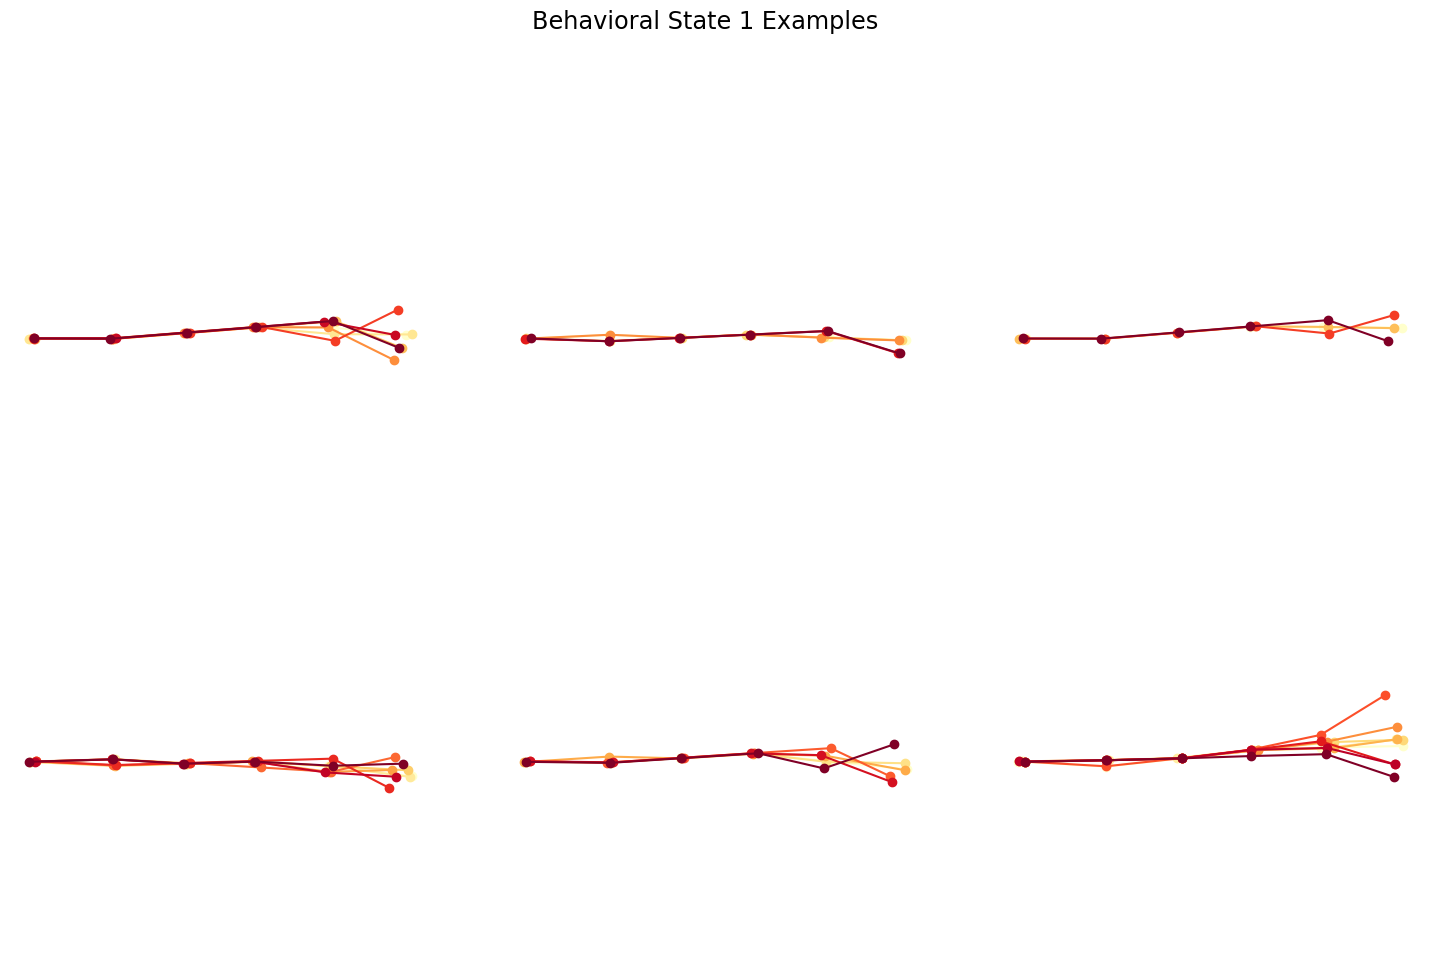

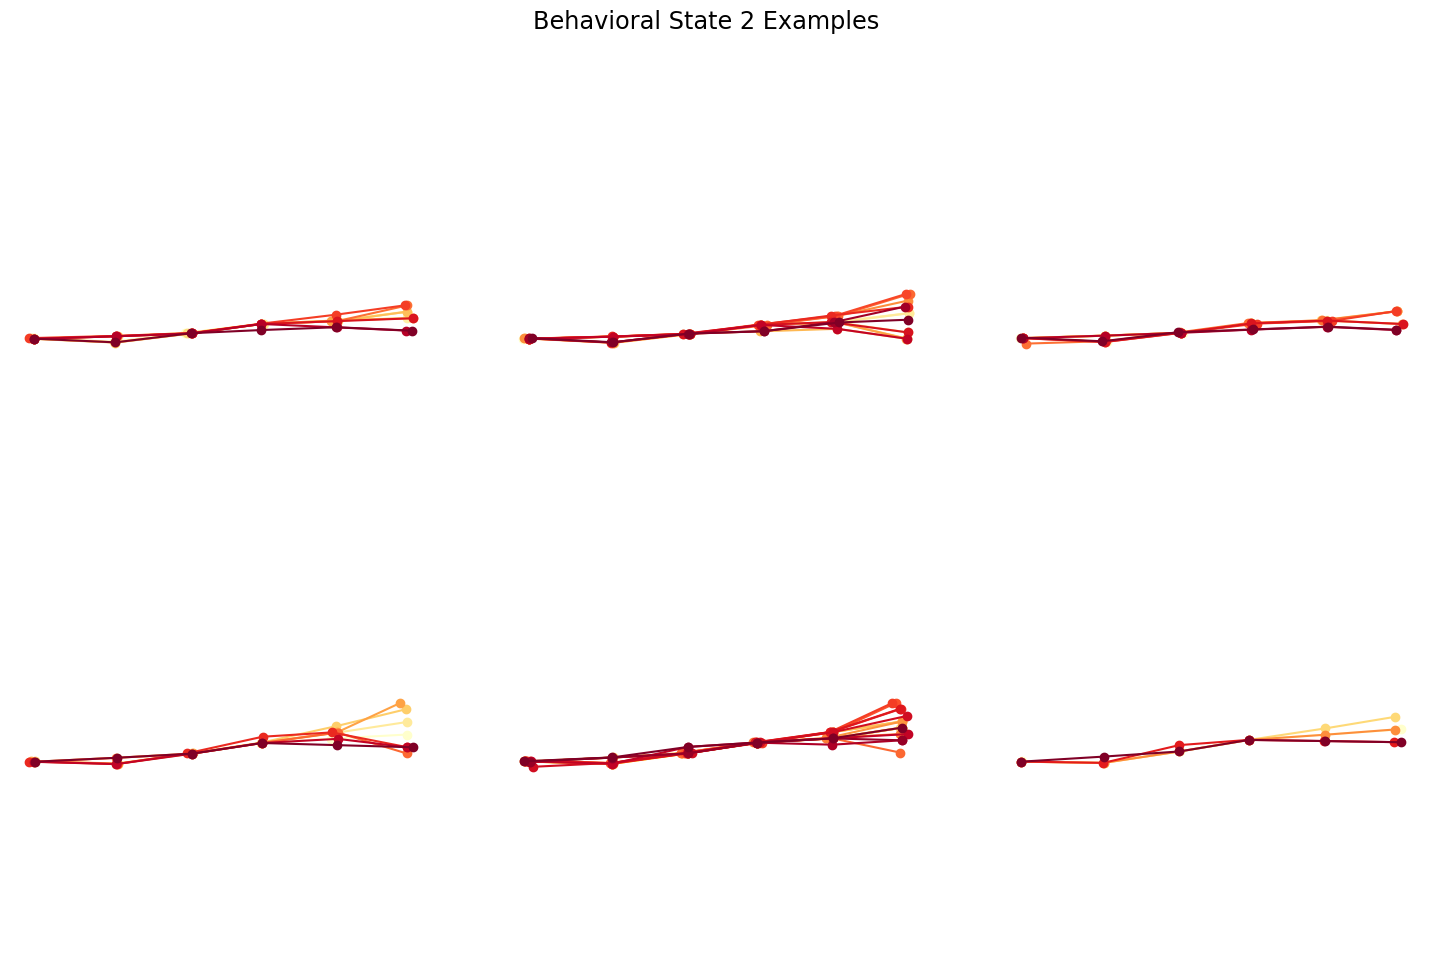

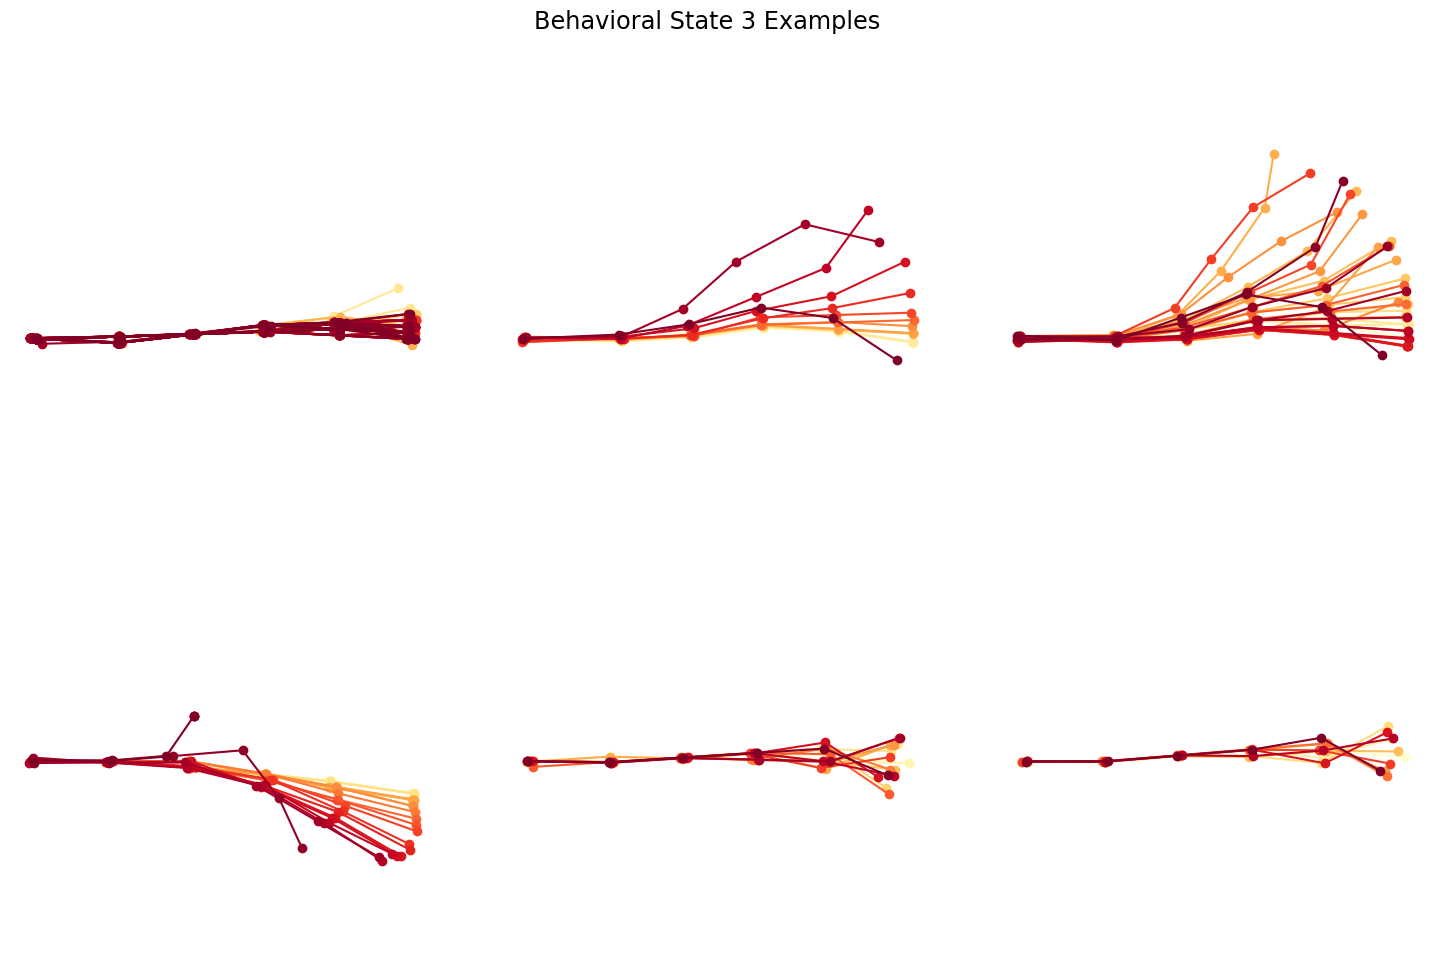

In [15]:
intes = [[[1917, 1924, 2], [1278,1283, 2], [6210, 6214,2], [2673, 2681, 2], [3229, 3235, 2], [7675, 7684, 3]],
         [[700, 710, 3], [5899, 5914, 3], [6050, 6060, 3], [10076, 10084, 3], [14949, 14971, 3], [14850, 14855, 3]],
         [[8593, 8936, 3], [57, 72, 1], [312, 352, 1], [3631, 3658, 0], [6110, 6126, 2], [9970, 9980, 2]]]

for i in range(len(intes)):
    inte = intes[i]
    title = 'Behavioral State ' + str(i+1) + ' Examples'
    visualization.plot_intervals(pdfs, inte, ncols = 3, title = title, fig_width=15, info = False)

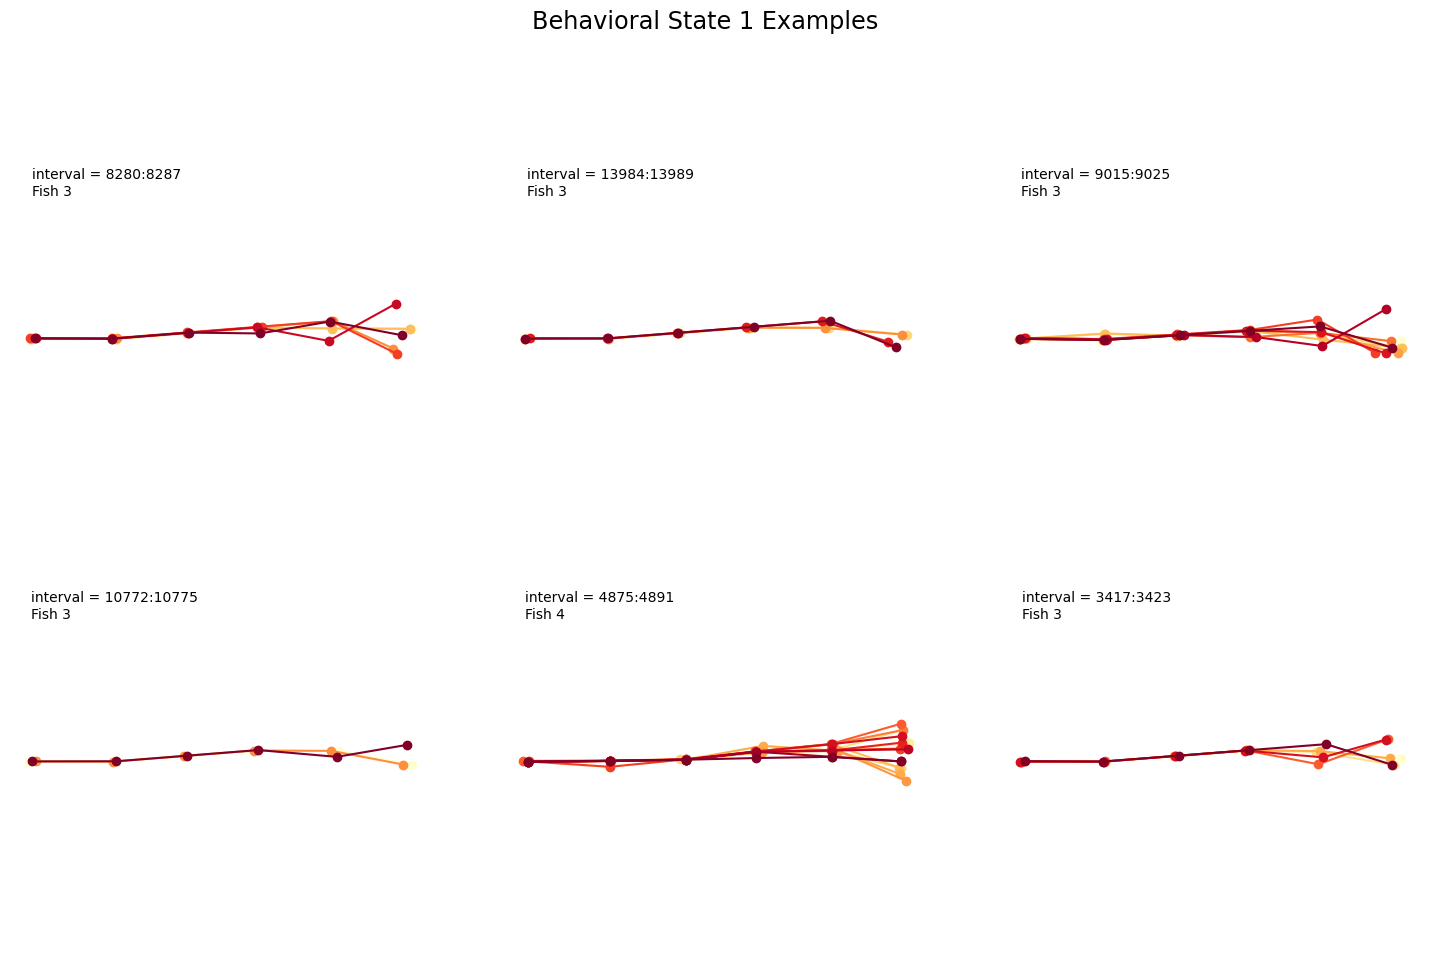

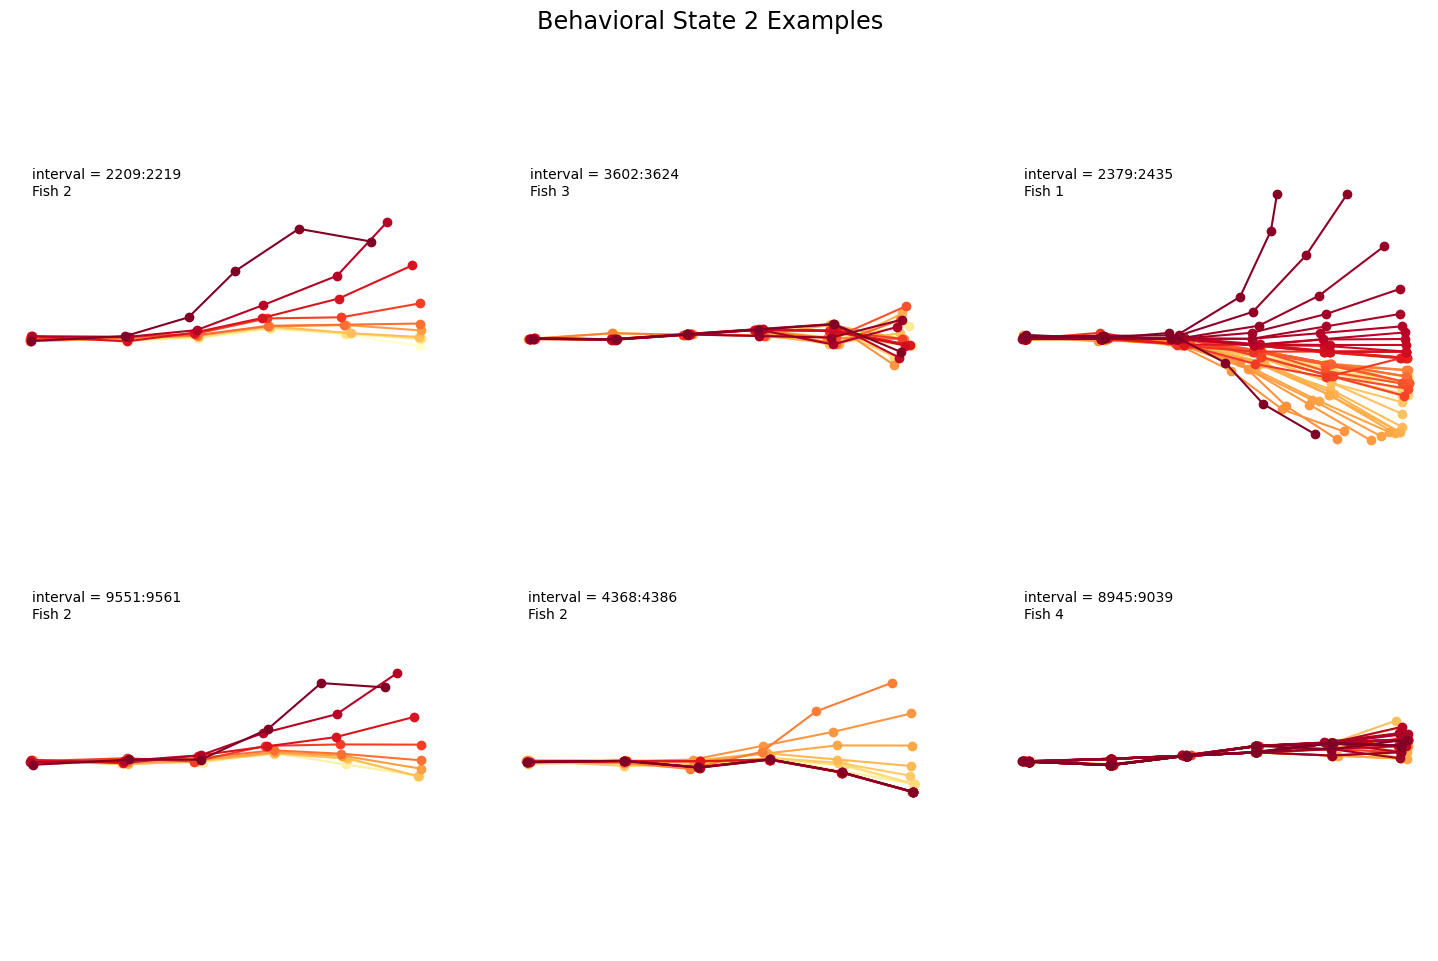

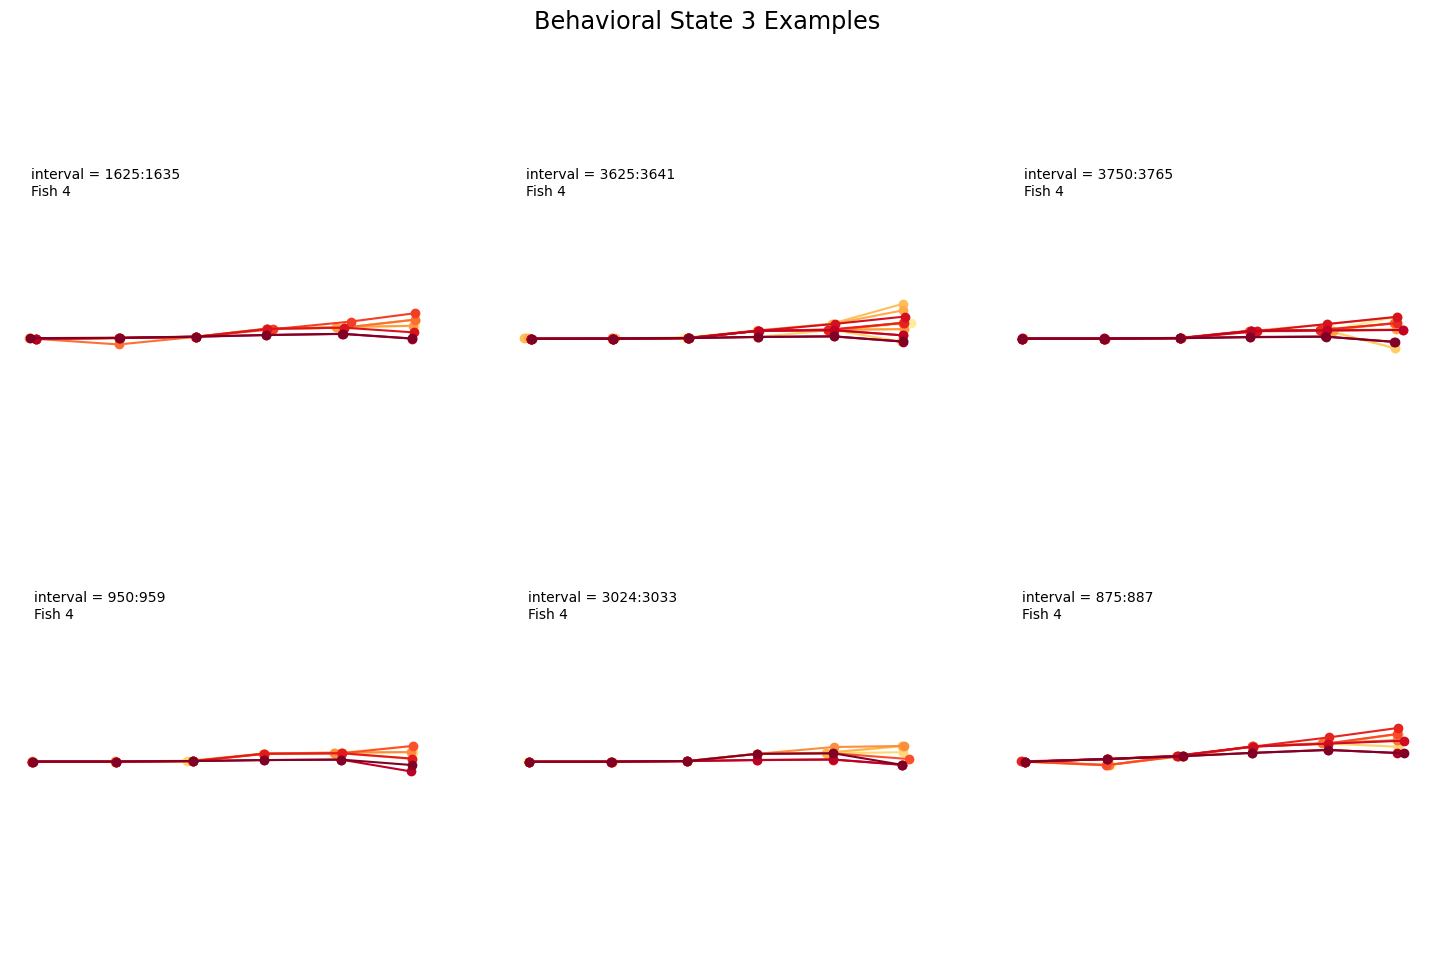

In [16]:
# This gets a reandom sample from each behavioral state
sample_size = 6
for i in range(len(clusters)):
    cluster = clusters[i]
    title = 'Behavioral State ' + str(i+1) + ' Examples'
    random_sample = np.random.choice(cluster, size=sample_size, replace=False)
    visualization.plot_intervals(pdfs, intervals[random_sample], ncols = 3, title = title, fig_width=15, info = True)

### Comparing Intervals of Activity

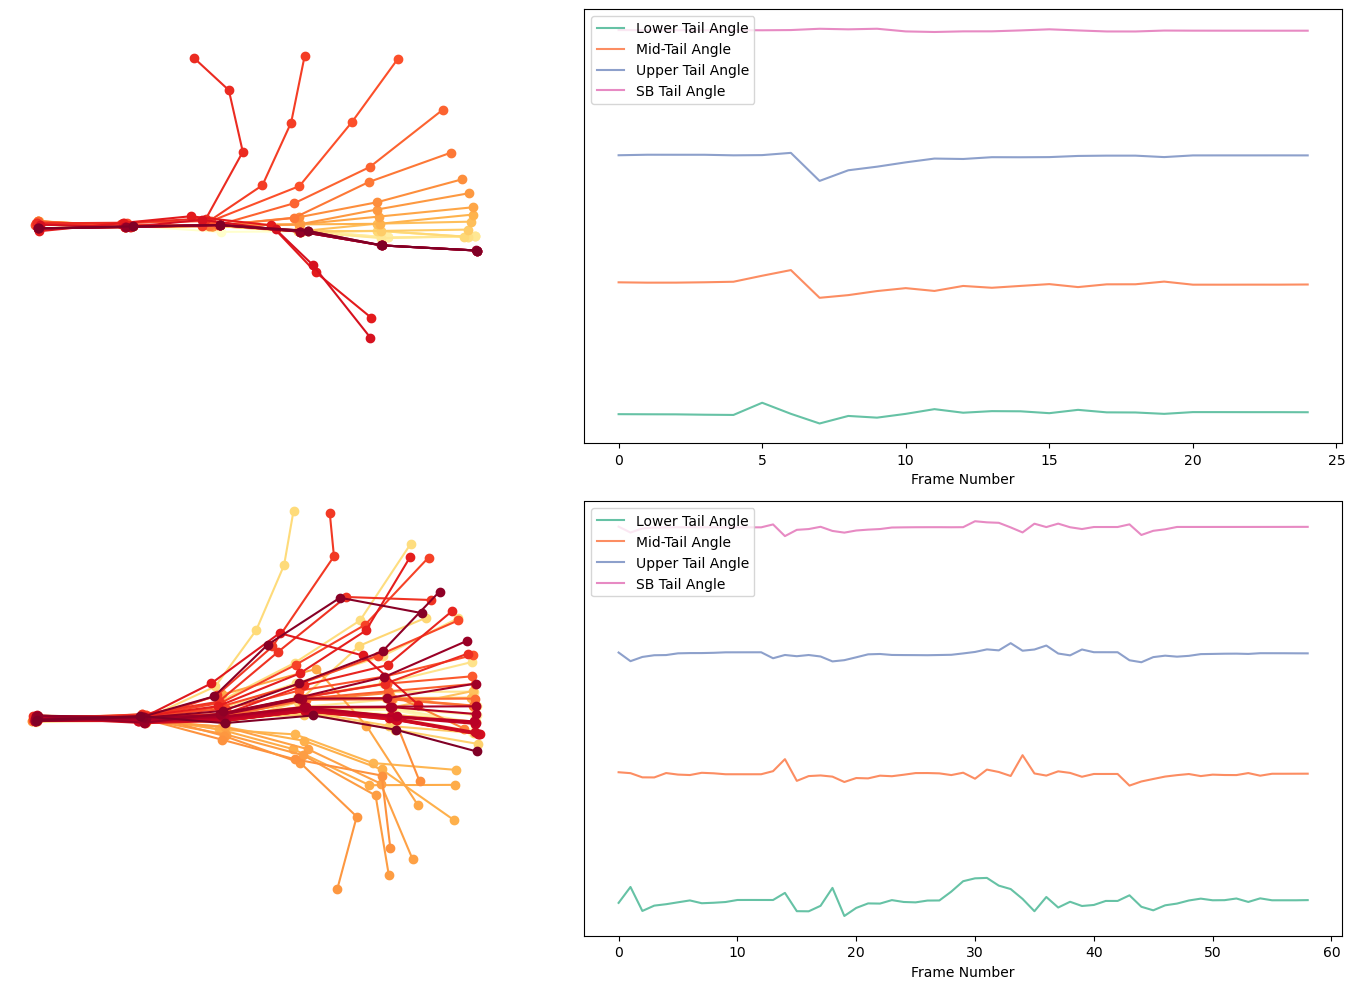

In [17]:
# Intervals to be compared
interval_array = np.array([[10506, 10531, 0],
                     [2208, 2267, 1]])
visualization.compare_intervals(dfs, pdfs, interval_array)

### Visualizing Behavioral State Clusters
In order to visualize how the data was clustered, the correlation matrix was projected onto 2d space using UMAP. The resulting graphs show a low-dimensional representation of how the intervals are arranged relative to each other according to dynamic time warping distance. These plots can further be used to illustrate how the different properties of each of the intervals (such as the length of interval and the recording from which the interval originated) have informed the clustering of the intervals into different behavioral states

Note: The downside to dimensionality reduction is that there exists no method to comprehend what the reduced dimensions are quantifiying. Therefore, the x and y axes are not shown in the following graphs.

Note: The UMAP projection used for visualization of the dataset is different to the UMAP projection used to find the nonlinear relationships between the data before clustering. This is because reducing the data to only two dimensions before clustering would eliminate too much important information in the data. The pre-clustering UMAP reduction reduces the set to several dimensions. The UMAP parameters that are used for visualization are also tuned to yield the greatest visual appeal of the graphs rather than to make clustering more accurate.

In [18]:
# Reduce the dynamic time warping distance matrix to two dimensions
reducer = umap.UMAP(n_neighbors = 100, min_dist = 0.8, random_state=1)
vis_correlation = reducer.fit_transform(correlation)

/Users/iman/Desktop/Zebrafish Kinematic Classification Pipeline/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


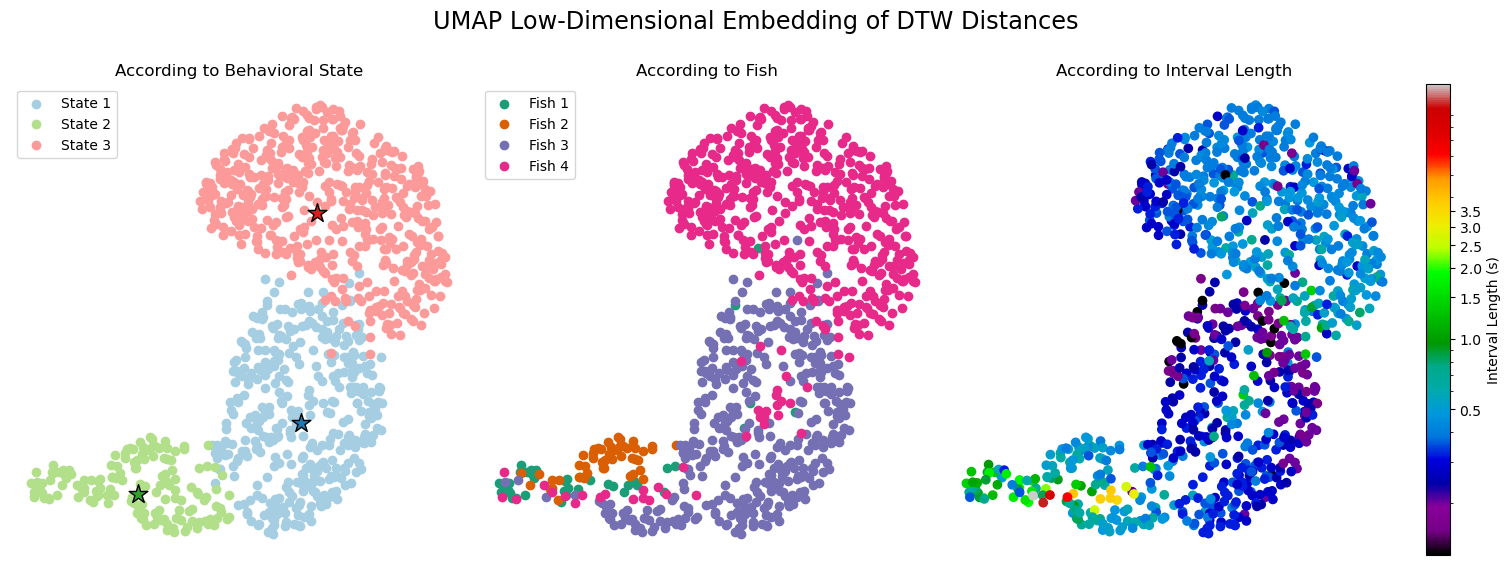

In [19]:
# Generate plots that show and compare the clustering of each interval, the recording associated with each interval, and the length of each interval
visualization.plot_clusters(intervals, medoids, clusters, vis_correlation, state_titles)

### Get Clips of Medoids in GIF and Video Formats

In [20]:
# Arrange videos into a list of arrays, with each array containing clips from a single recording
fish_vid_paths = []
fish_vid_paths.append(['Videos/240523_hcrt-reachr_cFos_1s_1IPI_#4_0.avi',
                  'Videos/240523_hcrt-reachr_cFos_1s_1IPI_#4_1.avi',
                  'Videos/240523_hcrt-reachr_cFos_1s_1IPI_#4_2.avi'])
fish_vid_paths.append(['Videos/240523_hcrt-reachr_cFos_1s_1IPI_#5_0.avi',
                  'Videos/240523_hcrt-reachr_cFos_1s_1IPI_#5_1.avi',
                  'Videos/240523_hcrt-reachr_cFos_1s_1IPI_#5_2.avi'])
fish_vid_paths.append(['Videos/240523_hcrt-reachr_cFos_1s_1IPI_#6_topview_wholefish_10min_25fps_0.avi',
                  'Videos/240523_hcrt-reachr_cFos_1s_1IPI_#6_topview_wholefish_10min_25fps_1-2.avi'])
fish_vid_paths.append(['Videos/240524_hcrt-reachr_cFos_constantON_#2_topview_wholefish_25fps_0.avi',
                  'Videos/240524_hcrt-reachr_cFos_constantON_#2_topview_wholefish_25fps_1.avi',
                  'Videos/240524_hcrt-reachr_cFos_constantON_#2_topview_wholefish_25fps_2.avi',
                  'Videos/240524_hcrt-reachr_cFos_constantON_#2_topview_wholefish_25fps_3.avi',
                  'Videos/240524_hcrt-reachr_cFos_constantON_#2_topview_wholefish_25fps_4.avi'])

In [21]:
# Upload videos
frame_lists = []
for i in range(len(fish_vid_paths)):
    fish_vid_path = fish_vid_paths[i]
    print('Recording ' + str(i+1))
    frame_lists.append(video.load_video_clips(fish_vid_path))

Recording 1


Loading Video 3 of 3: 100%|██████████| 3994/3994 [00:17<00:00, 226.68it/s]


Recording 2


Loading Video 3 of 3: 100%|██████████| 2698/2698 [00:06<00:00, 404.05it/s]


Recording 3


Loading Video 2 of 2: 100%|██████████| 9497/9497 [00:34<00:00, 272.46it/s]


Recording 4


Loading Video 5 of 5: 100%|██████████| 2396/2396 [00:16<00:00, 146.94it/s]


In [22]:
# Save medoids as gifs and avi videos. 
int_padding = 3 ## Add extra frames before and after interval to make it easier to visualize the entire behavior
for i in range(len(medoids)):
    interval_index = medoids[i] # Can be applied to other intervals if interval_index is just changed to the desired interval
    interval = intervals[interval_index]
    int_frame_list = frame_lists[interval[2]][interval[0]-int_padding:interval[1]+int_padding]
    int_df = pdfs[interval[2]].iloc[interval[0]-int_padding:interval[1]+int_padding,:]
    disp_frame_list = video.annotate_recording(int_df, int_frame_list)
    video.save_interval_as_gif(disp_frame_list, shuffle_dir + '/Visualizations/state' + str(i+1) + '_medoid')
    video.save_interval_as_video(disp_frame_list, shuffle_dir + '/Visualizations/state' + str(i+1) + '_medoid')

Preparing Video for Display: 100%|██████████| 20/20 [00:00<00:00, 379.54it/s]
